In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    auc,
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

In [3]:

# Upload the file manually

cloud = False
final_data = None
if cloud: 
    from google.colab import files

    uploaded = files.upload()
    final_data = pd.read_csv(list(uploaded.keys())[0])
else:
    final_data = pd.read_csv("final_data_with_long_titles.csv")

In [4]:
print("First 5 rows of the dataset:")
print(final_data.head())

# Check the shape of the dataset
print(f"Dataset shape: {final_data.shape}")

First 5 rows of the dataset:
   subject_id   hadm_id gender  age     classification  \
0    10000980  26913865      F   76  Only_hypertension   
1    10001217  24597018      F   55  Only_hypertension   
2    10001401  21544441      F   89  Only_hypertension   
3    10001884  26202981      F   76  Only_hypertension   
4    10002013  23581541      F   57  Only_hypertension   

   Intestinal infection due to Clostridium difficile[00845]  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   Unspecified septicemia[0389]  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   Streptococcus infection in co

In [5]:
missing_values = final_data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Series([], dtype: int64)


In [6]:
def clean_column_names(columns):
    """
    Replace problematic characters in column names with underscores.
    """
    return [
        str(col)
        .replace('[', '_')
        .replace(']', '_')
        .replace('<', '_')
        .replace('>', '_')
        .replace('/', '_')
        .replace(' ', '_')
        for col in columns
    ]

In [7]:

final_data['stroke'] = np.where(final_data['classification'] == 'stroke_after_hypertension', 1, 0)


data = final_data.drop(columns=['subject_id', 'hadm_id', 'classification'])


data.columns = clean_column_names(data.columns)


categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

# Splitting features and target
target = 'stroke'
X = data.drop(columns=[target])
y = data[target]


# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



SVM Accuracy: 0.7400815396080839
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.86      0.58      0.70     11618
           1       0.68      0.90      0.77     11193

    accuracy                           0.74     22811
   macro avg       0.77      0.74      0.73     22811
weighted avg       0.77      0.74      0.73     22811

Confusion Matrix for SVM:
 [[ 6769  4849]
 [ 1080 10113]]


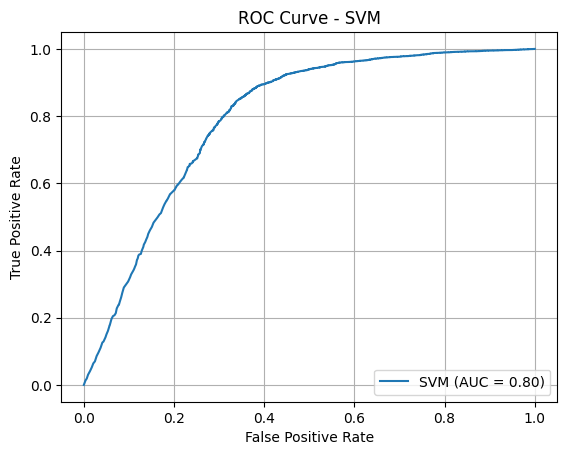

In [8]:
# Import the SVM classifier
from sklearn.svm import SVC
import joblib

pickle = False
svm_clf =None
if pickle : 
    
    svm_clf = SVC(probability=True, random_state=42)
    svm_clf.fit(X_train, y_train)
    joblib.dump(svm_clf, 'svm_classifier.pkl')
else: 
    svm_clf = joblib.load('svm_classifier.pkl')


y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report for SVM:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix for SVM:\n", confusion_matrix(y_test, y_pred_svm))

y_pred_svm_prob = svm_clf.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm_prob)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_svm_prob)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    svm_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=4
)

perm_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

print("Top 10 Important Features (Permutation Importance):\n", perm_importances.head(10))

top_n = 20
perm_imp_top_n = perm_importances.head(top_n)

plt.figure(figsize=(12, 10))
sns.barplot(
    x=perm_imp_top_n.values,
    y=perm_imp_top_n.index,
    palette='viridis',
    orient='h'
)
plt.title(f'Top {top_n} Feature Importances (Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy') 
plt.show()

KeyboardInterrupt: 